In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, identity, bmat, kron
#importing necessary modules

In [8]:
# Kerr BH parameters
a = 0.8       # Kerr spinn (rescaled with r_h so must be under 1)
M = 1              # From Eq. (6)  M=0.5 * r_h * (1 + k**2)
r_h = M+ np.sqrt(M**2 - a**2)        # Horizon radius (rescaled units)
k = a / r_h       # Dimensionless spin κ = a / r_h
r_c = r_h * (1 - k**2)  # From κ² = r_c / r_h
s = -2          #spin factor 0= scalar, +-1 =EM, +-2 =grav
m= 2            #mode number

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


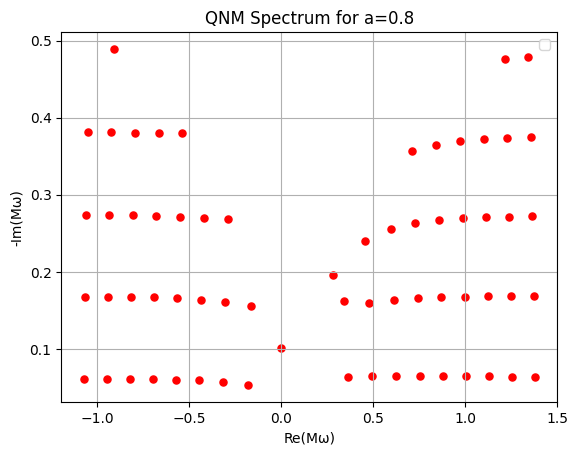

In [9]:
def qnm(N_ang,N_rad):
    x = np.array([np.cos(np.pi * i / N_ang) for i in range(N_ang + 1)])
    kai = np.array([np.cos(np.pi * i / N_rad) for i in range(N_rad + 1)])  
    sigma= (1+kai)/2          # sigma ∈ [0, 1], this does the same as defining the i_n coefficients like done in eq  (36) & (37)
    n1= N_rad+1
    n2= N_ang +1 
    ntot= n1*n2         #max k is 2 *ntot 
    k_max=2*ntot -2
    #Chebyshev grid
    sigma_2D= np.tensordot(sigma, np.ones(N_ang+1), axes=0)
    sigma_flat_c = sigma_2D.flatten().astype(complex)
    x_2D=np.tensordot(np.ones(N_rad+1), x , axes=0)
    x_flat_c = x_2D.flatten().astype(complex)
    #Differentiation matrices
    def diff_matrices(direction):
        if direction == 'x':
            nodes = x
        elif direction == 'sigma':
            nodes = kai
        else:
            raise ValueError("direction must be 'x' or 'sigma'")

        N = len(nodes)
        K=np.ones(N)
        K[0]=2
        K[-1]=2
        D=np.zeros((N,N))
        for i in range(N):                  #follows directly equation (39)
            for j in range(N):
                if i!=j:
                    D[i,j]=(K[i]*(-1)**(i-j))/(K[j]*(nodes[i]-nodes[j]))
                else:
                    if i == j ==0:
                        D[i, j] = (2 * (N-1)**2 + 1) / 6
                    elif i == j == N-1:
                        D[i, j] = -(2 * (N-1)**2 + 1) / 6
                    else:
                        D[i, j] = -nodes[j] / (2 * (1 - nodes[j]**2))
        if direction == 'x':
            return D 
        elif direction == 'sigma':
            return 2*D
    #1D differentiation matrices
    D_sig= diff_matrices("sigma")
    D_x= diff_matrices("x")
    I_sig= np.identity(n1)
    I_x=np.identity(n2)
    #2D matrices
    D_SIG= kron(D_sig, I_x,format='csr')   #1st derivative  sig direction
    D_X= kron(I_sig, D_x ,format='csr')        #1st derivative x direction
    D_SIG2=kron(D_sig @ D_sig, I_x,format='csr')  #2nd derivative sig direction
    D_X2=kron(I_sig, D_x @ D_x, format='csr')    #2nd derivative x direction


    #Define parameters for generating the differential operators L_1 and L_2
    delta1 = abs(m - s)
    delta2 = abs(m + s)
    #radial fixing gauge parameters, change to cauchy if needed.
    w_vector = (4.0*(sigma_flat_c + 1.0)
                + (k**2)*(-4.0*((k**2 + 1.0)**2)*sigma_flat_c**2
                           + 4.0*sigma_flat_c*(k**2)
                           + x_flat_c**2 + 7.0 + 4.0*(k**4 + 2.0*(k**2) + 2.0))).astype(complex)

    alpha1_vector = (sigma_flat_c * (4.0*(k**2)*sigma_flat_c**2
                                     - (k**2 + 1.0)*sigma_flat_c*(s + 3.0)
                                     - 2j*k*m*sigma_flat_c
                                     + 2.0*(s + 1.0))).astype(complex)

    alpha2_vector = ((sigma_flat_c**2 )* (1.0 - sigma_flat_c) * (1.0 - (k**2)*sigma_flat_c)).astype(complex)

    alpha0_vector = (0.5*(-delta1*(delta2 + 1.0) - delta2
                          + 4.0*(k**2)*sigma_flat_c**2
                          - 2.0*(k**2 + 1.0)*sigma_flat_c*(s + 1.0)
                          - m**2 - 4j*k*m*sigma_flat_c + s*(s + 2.0))).astype(complex)

    beta1_vector = (2.0*sigma_flat_c**2 * (2.0*(k**4)*(sigma_flat_c - 1.0)
                                           + (k**2)*(2.0*sigma_flat_c - 3.0) - 2.0) + 2.0).astype(complex)

    beta0_vector = (-2.0*sigma_flat_c*((k**2)*((k**2)*(s + 2.0) + 2.0*s + 3.0)
                    + s + 2.0)
                    + 6.0*(k**4 + k**2)*sigma_flat_c**2
                    - 2j*m*(2.0*(k**2 + 1.0)*k*sigma_flat_c + k)
                    + 2.0*s*(k**2 - 1j*k*x_flat_c + 1.0)).astype(complex)

    gamma1_vector = (delta1 - delta2 - x_flat_c*(delta1 + delta2 + 2.0)).astype(complex)
    gamma2_vector = (1.0 - x_flat_c**2).astype(complex)

    #Build L1 and L2
    L_1=(diags(alpha2_vector) @ D_SIG2 + diags(alpha1_vector) @ D_SIG + diags(alpha0_vector) + diags(gamma2_vector) @ D_X2 + diags(gamma1_vector) @ D_X)
    L_2= (diags(beta1_vector) @ D_SIG +diags(beta0_vector))
    I_ntot = identity(ntot, format='csr', dtype=complex)
    Z_ntot = diags(np.zeros(ntot, dtype=complex), format='csr')

    W_inv = diags(1.0 / w_vector,  dtype=complex, format='csr')
    L_top    = [Z_ntot, I_ntot]
    L_bottom = [W_inv @ L_1, W_inv @ L_2]
    L_operator = bmat([L_top, L_bottom], format='csr')  # 2N x 2N sparse matrix

    from scipy.sparse.linalg import eigs
    # Specify k = number of desired QNMs (eigenvalues)  
    eigenvals, eigenvecs = eigs(L_operator, k=k_max)           
    eig_norm=eigenvals*1j/(2*(1+k**2))

    #keep only decaying modes: Im(ω) < 0  
    mask_phys = np.isfinite(eig_norm) & (eig_norm.imag < 0.0) 
    eig_phys = eig_norm[mask_phys]

    # de-duplicate very close values
    def unique_by_tol(z, rtol=1e-6, atol=1e-9):
        keep = []
        for v in z:
            if not any(np.isclose(v, u, rtol=rtol, atol=atol) for u in keep):
                keep.append(v)
        return np.array(keep, dtype=complex)
    eig_phys = unique_by_tol(eig_phys)
    #if we want to look at a specific area of the complex plane
    mask_box = (
    (eig_phys.real >= -2.0) & (eig_phys.real <= 2.0) &
    (eig_phys.imag >= -1.0) & (eig_phys.imag <= 0.0)
    )
    eig_boxed = eig_phys[mask_box]
    return eig_boxed
def filtering_by_tol(high,low,TOL):
    # Relative differences matrix: shape (len(low), len(high))
    rel_diff = np.abs(1 - low[:, None] / high[None, :])

    # For each low eigenvalue, check if any high eigenvalue is within tol
    mask = (rel_diff < TOL).any(axis=1)
    return low[mask]


l=qnm(10,50)
h=qnm(11,55)

TOL=1e-3

plot=filtering_by_tol(h,l,TOL)
# --- plot ---
plt.figure()
plt.scatter(plot.real, -plot.imag, color='red', s=26)
plt.xlabel("Re(Mω)")
plt.ylabel("-Im(Mω)")
plt.title(f"QNM Spectrum for a={a}")
plt.legend()
plt.grid(True)
plt.show()

#Cauchy fixing gauge parameters
#w_vector= (((4*(k**2+1)**2)*sigma_flat_c)/(1-k**2)+ (k**2)*(x_flat_c**2+3)+4).astype(complex)

#alpha2_vector= (sigma_flat_c**2)*(1-sigma_flat_c).astype(complex)

#alpha1_vector=((sigma_flat_c*((k**2)*(2*(s+1)
#                                      -sigma_flat_c*(s+3)))
#                                      +2j*k*m*sigma_flat_c
#                                      +sigma_flat_c*(s+3)
#                                      -2*(s+1))/(k**2 -1)).astype(complex)

#alpha0_vector=-0.5*(delta1*(delta2+1)
#                    +delta2+m**2
 #                   -(4j*k*m*sigma_flat_c)/(k**2-1)
  #                  +2*sigma_flat_c*(s+1)-s*(s+2)).astype(complex)

#beta1_vector=(((-2*k**4)*(sigma_flat_c-1)**2 
 #                       +(2*k**2)*((sigma_flat_c)*sigma_flat_c +2) 
  #                      +4*sigma_flat_c**2 -2)/(k**2 - 1)).astype(complex)
#beta0_vector=((2/(k**2-1))*((-k**4)*(sigma_flat_c -1)*(s+1))
#                    +k**2 *(sigma_flat_c-1)
 #                   +(sigma_flat_c)*s +2*sigma_flat_c 
  #                  +mj*(k**3 *(2*sigma_flat_c -1) +2*k*sigma_flat_c +k)
   #                 -k**3*x_flat_c*s*1j
    #                +k*x_flat_c*s*1j).astype(complex)


In [ ]:
import os
from mpmath import mpc

# --- Save to Downloads ---
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "final_result.txt")

with open(downloads_path, "w") as f:
    # Parameters
    f.write("# Final QNM Results\n")
    f.write("# Parameters for l (low):  N_rad=50, N_ang=10\n")      #change Nrad and Nang accordingly
    f.write("# Parameters for h (high): N_rad=55, N_ang=11\n")       #change Nrad and Nang accordingly
    f.write("# Data format: Re\tIm\n\n")

    # Low spectrum (l)
    f.write("## Low spectrum (l)\n")
    for freq in l:
        f.write(f"{freq.real:.12e}\t{freq.imag:.12e}\n")
    f.write("\n")

    # High spectrum (h)
    f.write("## High spectrum (h)\n")
    for freq in h:
        f.write(f"{freq.real:.12e}\t{freq.imag:.12e}\n")
    f.write("\n")

    # Filtered spectrum (plot) with -Im (to match your scatter plot)
    f.write("## Filtered spectrum (plot)\n")
    for freq in plot:
        f.write(f"{freq.real:.12e}\t{-freq.imag:.12e}\n")
    f.write("\n")

print(f"Saved results to {downloads_path}")


Saved results to C:\Users\macab\Downloads\final_result.txt
